In [29]:
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi Plot
sns.set_theme(style="whitegrid")

In [30]:
# Path ke file CSV hasil eksperimen
# Sesuaikan path ini jika file dipindahkan
path_stable = 'results_stable/detailed_all_tests_20251105_083402.csv'
path_stress = 'results_stress/detailed_all_tests_20251108_235931.csv'

try:
    df_stable = pd.read_csv(path_stable)
    df_stress = pd.read_csv(path_stress)
    print("Data berhasil dimuat.")
except FileNotFoundError:
    print("Error: File CSV tidak ditemukan. Pastikan path file benar.")

Data berhasil dimuat.


## 1. Validasi Statistik (Paired T-Test)

Kita menggunakan Paired T-Test untuk membandingkan performa `No Cache` vs `Cache HIT` pada kondisi *Stable Load* dan *Stress Load*.
Hipotesis:
- $H_0$: Tidak ada perbedaan signifikan.
- $H_1$: Terdapat perbedaan signifikan (Cache HIT lebih cepat).

In [31]:
results = []

for scenario_name, df in [('Stable Load', df_stable), ('Stress Load', df_stress)]:
    print(f'--- HASIL T-TEST ({scenario_name}) ---')
    
    for endpoint in ['income', 'automatic']:
        subset = df[df['Endpoint'] == endpoint].copy()
        
        # Bersihkan data NaN
        subset = subset.dropna(subset=['NoCache_Avg_ms', 'CacheHit_Avg_ms'])
        
        if len(subset) > 1:
            t_stat, p_val = stats.ttest_rel(subset['NoCache_Avg_ms'], subset['CacheHit_Avg_ms'])
            
            significance = "Sangat Signifikan" if p_val < 0.001 else "Signifikan" if p_val < 0.05 else "Tidak Signifikan"
            
            results.append({
                'Scenario': scenario_name,
                'Endpoint': endpoint,
                'T-Statistic': t_stat,
                'P-Value': p_val,
                'Kesimpulan': significance
            })
            
            print(f"Endpoint: {endpoint}")
            print(f"  t-stat: {t_stat:.4f}")
            print(f"  p-value: {p_val:.4e} ({significance})")
            print("-" * 30)
    print("\n")

# Tampilkan dalam bentuk DataFrame agar lebih rapi
pd.DataFrame(results)

--- HASIL T-TEST (Stable Load) ---
Endpoint: income
  t-stat: 8.1433
  p-value: 2.2061e-12 (Sangat Signifikan)
------------------------------
Endpoint: automatic
  t-stat: 11.8211
  p-value: 6.1280e-20 (Sangat Signifikan)
------------------------------


--- HASIL T-TEST (Stress Load) ---
Endpoint: income
  t-stat: 3.6268
  p-value: 4.7787e-04 (Sangat Signifikan)
------------------------------
Endpoint: automatic
  t-stat: 6.9642
  p-value: 5.4610e-10 (Sangat Signifikan)
------------------------------




,Scenario,Endpoint,T-Statistic,P-Value,Kesimpulan
0,Stable Load,income,8.143342,2.206069e-12,Sangat Signifikan
1,Stable Load,automatic,11.821099,6.127958e-20,Sangat Signifikan
2,Stress Load,income,3.626815,4.778716e-04,Sangat Signifikan
3,Stress Load,automatic,6.964223,5.460959e-10,Sangat Signifikan


## 2. Validasi Kompleksitas (Power Law Fit)

Kita memodelkan hubungan antara `Payload Size` ($x$) dan `Response Time` ($y$) menggunakan fungsi Power Law:
$$ y = a \cdot x^b $$

Nilai $b$ (eksponen) menunjukkan kelas kompleksitas:
- $b \approx 1$: Linear ($O(n)$)
- $b \approx 2$: Kuadratik ($O(n^2)$)
- $b \approx 0$: Konstan ($O(1)$)

--- HASIL FITTING KOMPLEKSITAS (High Load) ---


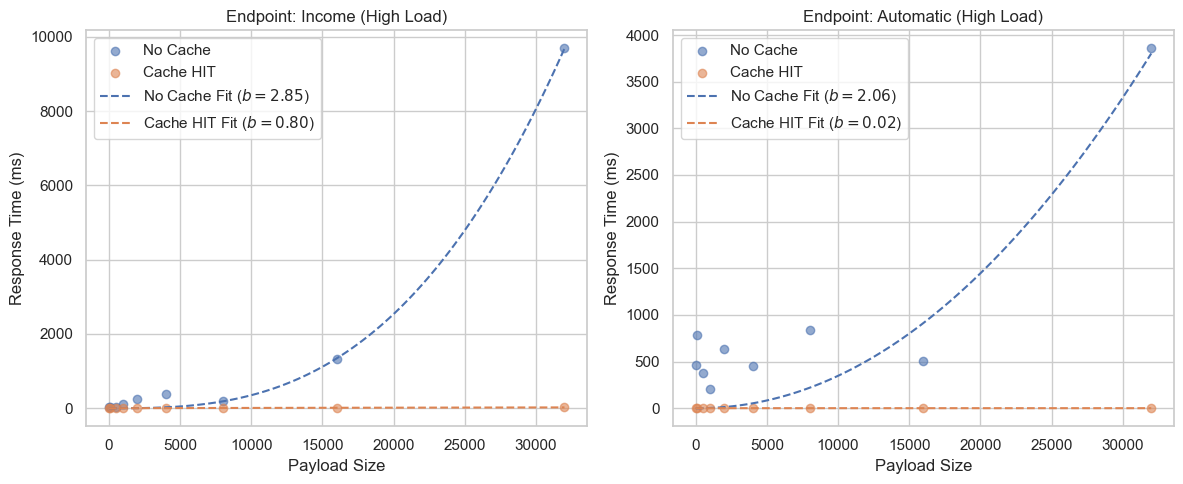

--- HASIL FITTING KOMPLEKSITAS (Normal Load) ---


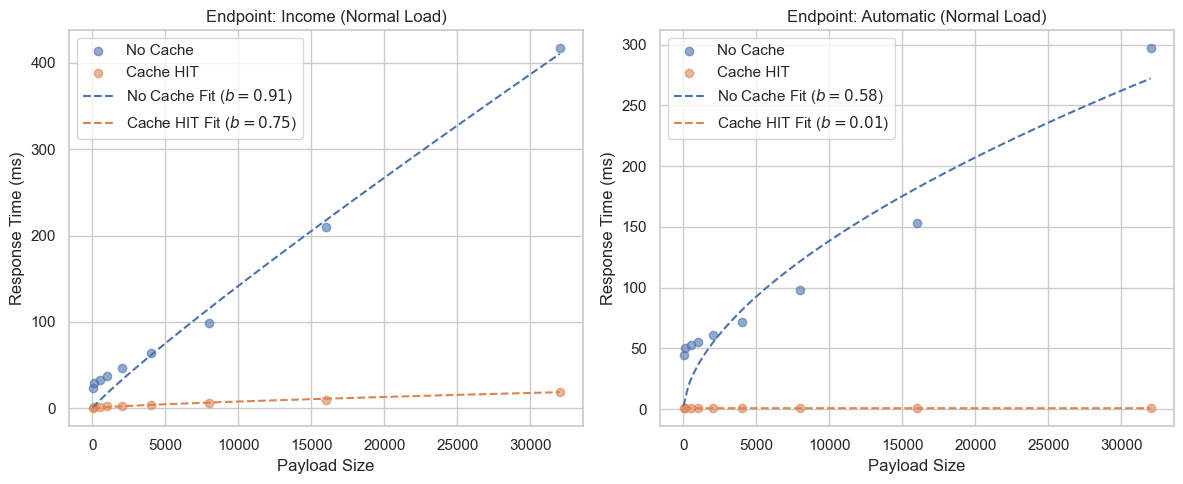

,Scenario,Endpoint,Type,b-value
0,High Load,income,No Cache,2.850807
1,High Load,income,Cache HIT,0.802852
2,High Load,automatic,No Cache,2.056865
3,High Load,automatic,Cache HIT,0.018913
4,Normal Load,income,No Cache,0.913520
5,Normal Load,income,Cache HIT,0.748397
6,Normal Load,automatic,No Cache,0.580047
7,Normal Load,automatic,Cache HIT,0.007805


In [ ]:
def power_law(x, a, b):
    return a * np.power(x, b)

def analyze_complexity(df, scenario_name):
    print(f'--- HASIL FITTING KOMPLEKSITAS ({scenario_name}) ---')
    
    fit_results = []
    plt.figure(figsize=(12, 5))
    
    for i, endpoint in enumerate(['income', 'automatic']):
        subset = df[df['Endpoint'] == endpoint]
        
        # Group by PayloadSize to get mean values for fitting
        grouped = subset.groupby('PayloadSize').agg({
            'NoCache_Avg_ms': 'mean',
            'CacheHit_Avg_ms': 'mean'
        }).reset_index()
        
        x = grouped['PayloadSize'].values
        
        # Plotting setup
        plt.subplot(1, 2, i+1)
        plt.title(f"Endpoint: {endpoint.capitalize()} ({scenario_name})")
        plt.xlabel("Payload Size")
        plt.ylabel("Response Time (ms)")
        
        # Scatter points
        plt.scatter(x, grouped['NoCache_Avg_ms'], label='No Cache', alpha=0.6)
        plt.scatter(x, grouped['CacheHit_Avg_ms'], label='Cache HIT', alpha=0.6)
        
        try:
            # Fit No Cache
            popt_nc, _ = curve_fit(power_law, x, grouped['NoCache_Avg_ms'].values, p0=[1, 1], maxfev=10000)
            fit_results.append({'Scenario': scenario_name, 'Endpoint': endpoint, 'Type': 'No Cache', 'b-value': popt_nc[1]})
            
            # Plot Fit Line
            x_line = np.linspace(min(x), max(x), 100)
            plt.plot(x_line, power_law(x_line, *popt_nc), '--', label=f'No Cache Fit ($b={popt_nc[1]:.2f}$)')
    
            # Fit Cache HIT
            popt_ch, _ = curve_fit(power_law, x, grouped['CacheHit_Avg_ms'].values, p0=[1, 1], maxfev=10000)
            fit_results.append({'Scenario': scenario_name, 'Endpoint': endpoint, 'Type': 'Cache HIT', 'b-value': popt_ch[1]})
            
            # Plot Fit Line
            plt.plot(x_line, power_law(x_line, *popt_ch), '--', label=f'Cache HIT Fit ($b={popt_ch[1]:.2f}$)')
            
        except Exception as e:
            print(f'Fitting failed for {endpoint}: {e}')
            
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return fit_results

# Analisis High Load
res_stress = analyze_complexity(df_stress, "High Load")

# Analisis Stable Load
res_stable = analyze_complexity(df_stable, "Normal Load")

pd.DataFrame(res_stress + res_stable)